In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from prophet import Prophet
import warnings; 
warnings.simplefilter('ignore')

def escrever_csv(dfa, nome, comIndex): 
    dfa.to_csv(nome+'.csv', index=bool(comIndex))
    


# Ler

- Dados totais

In [2]:
original1 = pd.read_csv("D:\\B&N Dados\\Delta\\Stocks\\Stocks2022\\Stocks_Delta_2022_Limpo.csv")
original2 = pd.read_csv("D:\\B&N Dados\\Delta\\Stocks\\Stocks2023\\Stocks_Delta_2023_Limpo.csv")

original = pd.concat([original1,original2], ignore_index=True)
original["DATA"] = pd.to_datetime(original["DATA"])

In [41]:
original = original[original['DATA'] != '2023-05-10']

In [42]:
original.tail()

,DATA,EAN,DESC_ARTIGO,STORE,STORE_NAME,INTRANSIT,EXPECTED,PRES_STOCK,STOCK,STOCK_1_Dias_Antes,SELLOUT,SELLOUT_1_Dias_Antes
12929550,2023-05-05,5607623011106,VT DIZERES ADEGA MAYOR ALENTEJO 75CL,6089,MDL BEJA RETAIL,0,0,6,5.0,5.0,0.0,0.0
12929551,2023-05-06,5607623011106,VT DIZERES ADEGA MAYOR ALENTEJO 75CL,6089,MDL BEJA RETAIL,0,0,6,5.0,5.0,0.0,0.0
12929552,2023-05-07,5607623011106,VT DIZERES ADEGA MAYOR ALENTEJO 75CL,6089,MDL BEJA RETAIL,0,0,6,5.0,5.0,0.0,0.0
12929553,2023-05-08,5607623011106,VT DIZERES ADEGA MAYOR ALENTEJO 75CL,6089,MDL BEJA RETAIL,0,0,6,5.0,5.0,0.0,0.0
12929554,2023-05-09,5607623011106,VT DIZERES ADEGA MAYOR ALENTEJO 75CL,6089,MDL BEJA RETAIL,0,0,6,5.0,5.0,0.0,0.0


- Produtos e lojas alvo

In [43]:
# Ler ficheiro para dataframe
df_produtos = pd.read_csv('D:\\B&N Dados\\Delta\\Piloto\\produtos.txt', header=None)
df_lojas = pd.read_csv('D:\\B&N Dados\\Delta\\Piloto\\lojas.txt', header=None)

# Passar para uma lista
produtos = df_produtos[0].tolist()
lojas = original["STORE"].unique().tolist()#df_lojas[0].tolist() 

# Definir Base de estudo

In [44]:
%%time
# Limitar dados para que a base apenas integre os produtos e lojas alvo
df_Juntos = original[(original['STORE'].isin(lojas)) & (original['DESC_ARTIGO'].isin(produtos))].copy()

# Criar dicionário para receber as bases de cada produto para cada loja
all_dataframes = {}

# Preencher o dicionário com as combinações todas de produtos por loja
for loja in lojas:
    for produto in produtos:
        # Create a new DataFrame for each loja and produto
        df = df_Juntos[(df_Juntos['STORE'] == loja) & (df_Juntos['DESC_ARTIGO'] == produto)].copy()
        
        # Generate a unique name for the DataFrame
        df_name = f'{loja}_{produto}'
        
        # Assign the DataFrame to the unique name
        all_dataframes[df_name] = df



CPU times: total: 4min 8s
Wall time: 3min 54s


In [35]:
df_Juntos.shape

AttributeError: 'dict' object has no attribute 'shape'

In [32]:
df_Juntos[(df_Juntos["STORE"]==3) & (df_Juntos["DESC_ARTIGO"]=="CAFÉ BELLISSIMO INTENSO 200GR")].head()

,DATA,EAN,DESC_ARTIGO,STORE,STORE_NAME,INTRANSIT,EXPECTED,PRES_STOCK,STOCK,STOCK_1_Dias_Antes,SELLOUT,SELLOUT_1_Dias_Antes
599250,2022-01-01,5601082049946,CAFÉ BELLISSIMO INTENSO 200GR,3,CNT CASCAIS,0,0,16,115.0,115.0,0.0,1.0
599251,2022-01-02,5601082049946,CAFÉ BELLISSIMO INTENSO 200GR,3,CNT CASCAIS,0,0,16,109.0,115.0,6.0,0.0
599252,2022-01-03,5601082049946,CAFÉ BELLISSIMO INTENSO 200GR,3,CNT CASCAIS,0,0,16,100.0,109.0,9.0,6.0
599253,2022-01-04,5601082049946,CAFÉ BELLISSIMO INTENSO 200GR,3,CNT CASCAIS,0,0,16,91.0,100.0,9.0,9.0
599254,2022-01-05,5601082049946,CAFÉ BELLISSIMO INTENSO 200GR,3,CNT CASCAIS,0,0,16,74.0,91.0,17.0,9.0


In [39]:
#Sera = {key: df for key, df in all_dataframes.items() if not df["SELLOUT"].isna().all()}
for key, df in Sera.items():
    if df["SELLOUT"].isna().all():
        print(key)

# Treino e output

- Definir número de períodos

- Correr modelo

In [ ]:
%%time
base_Alterada=[]


for key, df in Sera.items():

    # Assuming your features are in columns 'x1' and 'x2', and the target is in column 'y'
    df_Treino = df[["DATA", "SELLOUT"]].rename(columns={"DATA":"ds","SELLOUT":"y"})
    df_Treino = df_Treino[df_Treino["ds"] < "01-01-2023"]
    
    if df_Treino["ds"].isna().all():
        continue
    
    df_Final = df[["DATA", "STORE", "STORE_NAME", "DESC_ARTIGO", "SELLOUT"]]
    
    
    # Train the machine learning model
    m = Prophet(interval_width=0.95, daily_seasonality=True)
    model = m.fit(df_Treino)
    
    # Make predictions    
    future = m.make_future_dataframe(periods=1000, freq="D")
    forecast = m.predict(future)
    forecast = forecast[forecast["ds"] >= "01-01-2023"]
    
    # Add the predictions as a new column to the dataframe
    df_Final = pd.merge(df_Final, forecast[["ds", "yhat"]], how="left", left_on="DATA", right_on="ds")
    
    # Append the modified dataframe to the list
    base_Alterada.append(df_Final)

# Fazer uma base com os dados todos
base_Final = pd.concat(base_Alterada)

13:09:07 - cmdstanpy - INFO - Chain [1] start processing
13:09:07 - cmdstanpy - INFO - Chain [1] done processing
13:09:08 - cmdstanpy - INFO - Chain [1] start processing
13:09:08 - cmdstanpy - INFO - Chain [1] done processing
13:09:09 - cmdstanpy - INFO - Chain [1] start processing
13:09:09 - cmdstanpy - INFO - Chain [1] done processing
13:09:09 - cmdstanpy - INFO - Chain [1] start processing
13:09:10 - cmdstanpy - INFO - Chain [1] done processing
13:09:10 - cmdstanpy - INFO - Chain [1] start processing
13:09:10 - cmdstanpy - INFO - Chain [1] done processing
13:09:11 - cmdstanpy - INFO - Chain [1] start processing
13:09:11 - cmdstanpy - INFO - Chain [1] done processing
13:09:12 - cmdstanpy - INFO - Chain [1] start processing
13:09:12 - cmdstanpy - INFO - Chain [1] done processing
13:09:12 - cmdstanpy - INFO - Chain [1] start processing
13:09:13 - cmdstanpy - INFO - Chain [1] done processing
13:09:13 - cmdstanpy - INFO - Chain [1] start processing
13:09:13 - cmdstanpy - INFO - Chain [1]

13:10:05 - cmdstanpy - INFO - Chain [1] done processing
13:10:06 - cmdstanpy - INFO - Chain [1] start processing
13:10:06 - cmdstanpy - INFO - Chain [1] done processing
13:10:07 - cmdstanpy - INFO - Chain [1] start processing
13:10:07 - cmdstanpy - INFO - Chain [1] done processing
13:10:08 - cmdstanpy - INFO - Chain [1] start processing
13:10:08 - cmdstanpy - INFO - Chain [1] done processing
13:10:08 - cmdstanpy - INFO - Chain [1] start processing
13:10:09 - cmdstanpy - INFO - Chain [1] done processing
13:10:09 - cmdstanpy - INFO - Chain [1] start processing
13:10:10 - cmdstanpy - INFO - Chain [1] done processing
13:10:10 - cmdstanpy - INFO - Chain [1] start processing
13:10:10 - cmdstanpy - INFO - Chain [1] done processing
13:10:11 - cmdstanpy - INFO - Chain [1] start processing
13:10:11 - cmdstanpy - INFO - Chain [1] done processing
13:10:12 - cmdstanpy - INFO - Chain [1] start processing
13:10:12 - cmdstanpy - INFO - Chain [1] done processing
13:10:13 - cmdstanpy - INFO - Chain [1] 

13:11:13 - cmdstanpy - INFO - Chain [1] done processing
13:11:13 - cmdstanpy - INFO - Chain [1] start processing
13:11:13 - cmdstanpy - INFO - Chain [1] done processing
13:11:14 - cmdstanpy - INFO - Chain [1] start processing
13:11:14 - cmdstanpy - INFO - Chain [1] done processing
13:11:15 - cmdstanpy - INFO - Chain [1] start processing
13:11:15 - cmdstanpy - INFO - Chain [1] done processing
13:11:16 - cmdstanpy - INFO - Chain [1] start processing
13:11:16 - cmdstanpy - INFO - Chain [1] done processing
13:11:17 - cmdstanpy - INFO - Chain [1] start processing
13:11:17 - cmdstanpy - INFO - Chain [1] done processing
13:11:18 - cmdstanpy - INFO - Chain [1] start processing
13:11:18 - cmdstanpy - INFO - Chain [1] done processing
13:11:19 - cmdstanpy - INFO - Chain [1] start processing
13:11:19 - cmdstanpy - INFO - Chain [1] done processing
13:11:20 - cmdstanpy - INFO - Chain [1] start processing
13:11:20 - cmdstanpy - INFO - Chain [1] done processing
13:11:21 - cmdstanpy - INFO - Chain [1] 

13:12:17 - cmdstanpy - INFO - Chain [1] done processing
13:12:18 - cmdstanpy - INFO - Chain [1] start processing
13:12:18 - cmdstanpy - INFO - Chain [1] done processing
13:12:19 - cmdstanpy - INFO - Chain [1] start processing
13:12:19 - cmdstanpy - INFO - Chain [1] done processing
13:12:20 - cmdstanpy - INFO - Chain [1] start processing
13:12:20 - cmdstanpy - INFO - Chain [1] done processing
13:12:21 - cmdstanpy - INFO - Chain [1] start processing
13:12:21 - cmdstanpy - INFO - Chain [1] done processing
13:12:21 - cmdstanpy - INFO - Chain [1] start processing
13:12:22 - cmdstanpy - INFO - Chain [1] done processing
13:12:22 - cmdstanpy - INFO - Chain [1] start processing
13:12:22 - cmdstanpy - INFO - Chain [1] done processing
13:12:23 - cmdstanpy - INFO - Chain [1] start processing
13:12:23 - cmdstanpy - INFO - Chain [1] done processing
13:12:24 - cmdstanpy - INFO - Chain [1] start processing
13:12:24 - cmdstanpy - INFO - Chain [1] done processing
13:12:26 - cmdstanpy - INFO - Chain [1] 

13:13:23 - cmdstanpy - INFO - Chain [1] done processing
13:13:24 - cmdstanpy - INFO - Chain [1] start processing
13:13:24 - cmdstanpy - INFO - Chain [1] done processing
13:13:25 - cmdstanpy - INFO - Chain [1] start processing
13:13:25 - cmdstanpy - INFO - Chain [1] done processing
13:13:25 - cmdstanpy - INFO - Chain [1] start processing
13:13:25 - cmdstanpy - INFO - Chain [1] done processing
13:13:26 - cmdstanpy - INFO - Chain [1] start processing
13:13:26 - cmdstanpy - INFO - Chain [1] done processing
13:13:27 - cmdstanpy - INFO - Chain [1] start processing
13:13:27 - cmdstanpy - INFO - Chain [1] done processing
13:13:28 - cmdstanpy - INFO - Chain [1] start processing
13:13:28 - cmdstanpy - INFO - Chain [1] done processing
13:13:29 - cmdstanpy - INFO - Chain [1] start processing
13:13:29 - cmdstanpy - INFO - Chain [1] done processing
13:13:29 - cmdstanpy - INFO - Chain [1] start processing
13:13:29 - cmdstanpy - INFO - Chain [1] done processing
13:13:30 - cmdstanpy - INFO - Chain [1] 

13:14:25 - cmdstanpy - INFO - Chain [1] done processing
13:14:26 - cmdstanpy - INFO - Chain [1] start processing
13:14:27 - cmdstanpy - INFO - Chain [1] done processing
13:14:27 - cmdstanpy - INFO - Chain [1] start processing
13:14:27 - cmdstanpy - INFO - Chain [1] done processing
13:14:28 - cmdstanpy - INFO - Chain [1] start processing
13:14:28 - cmdstanpy - INFO - Chain [1] done processing
13:14:29 - cmdstanpy - INFO - Chain [1] start processing
13:14:29 - cmdstanpy - INFO - Chain [1] done processing
13:14:30 - cmdstanpy - INFO - Chain [1] start processing
13:14:30 - cmdstanpy - INFO - Chain [1] done processing
13:14:31 - cmdstanpy - INFO - Chain [1] start processing
13:14:31 - cmdstanpy - INFO - Chain [1] done processing
13:14:32 - cmdstanpy - INFO - Chain [1] start processing
13:14:32 - cmdstanpy - INFO - Chain [1] done processing
13:14:33 - cmdstanpy - INFO - Chain [1] start processing
13:14:33 - cmdstanpy - INFO - Chain [1] done processing
13:14:33 - cmdstanpy - INFO - Chain [1] 

# Verificar

In [47]:
base_Final.shape

(373475, 7)

In [11]:
base_Final.head()

,DATA,STORE,STORE_NAME,DESC_ARTIGO,SELLOUT,ds,yhat
0,2022-03-03,1,CNT MATOSINHOS,CAFÉ DELTA Q MYTHIQ 80CAP,0.0,2022-03-03,1.016088
1,2022-03-04,1,CNT MATOSINHOS,CAFÉ DELTA Q MYTHIQ 80CAP,0.0,2022-03-04,1.983218
2,2022-03-05,1,CNT MATOSINHOS,CAFÉ DELTA Q MYTHIQ 80CAP,0.0,2022-03-05,1.806038
3,2022-03-06,1,CNT MATOSINHOS,CAFÉ DELTA Q MYTHIQ 80CAP,0.0,2022-03-06,1.835104
4,2022-03-07,1,CNT MATOSINHOS,CAFÉ DELTA Q MYTHIQ 80CAP,0.0,2022-03-07,1.064384


In [12]:
base_Final["yhat"] = np.where(base_Final["yhat"]<0, 0, base_Final["yhat"])

<Axes: xlabel='DATA', ylabel='yhat'>

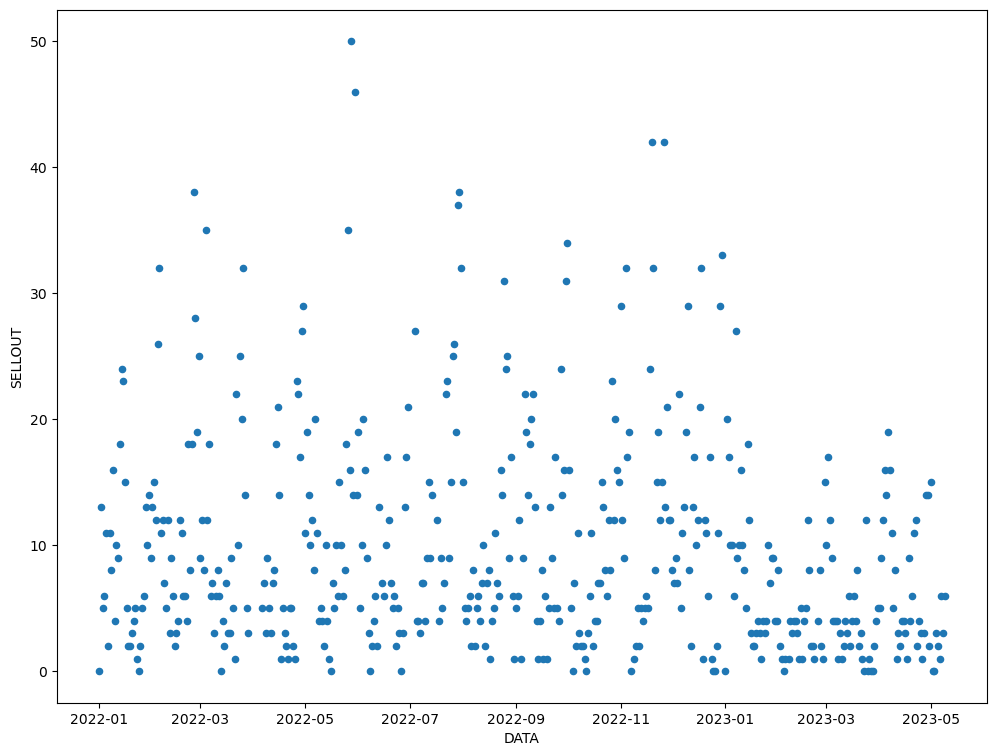

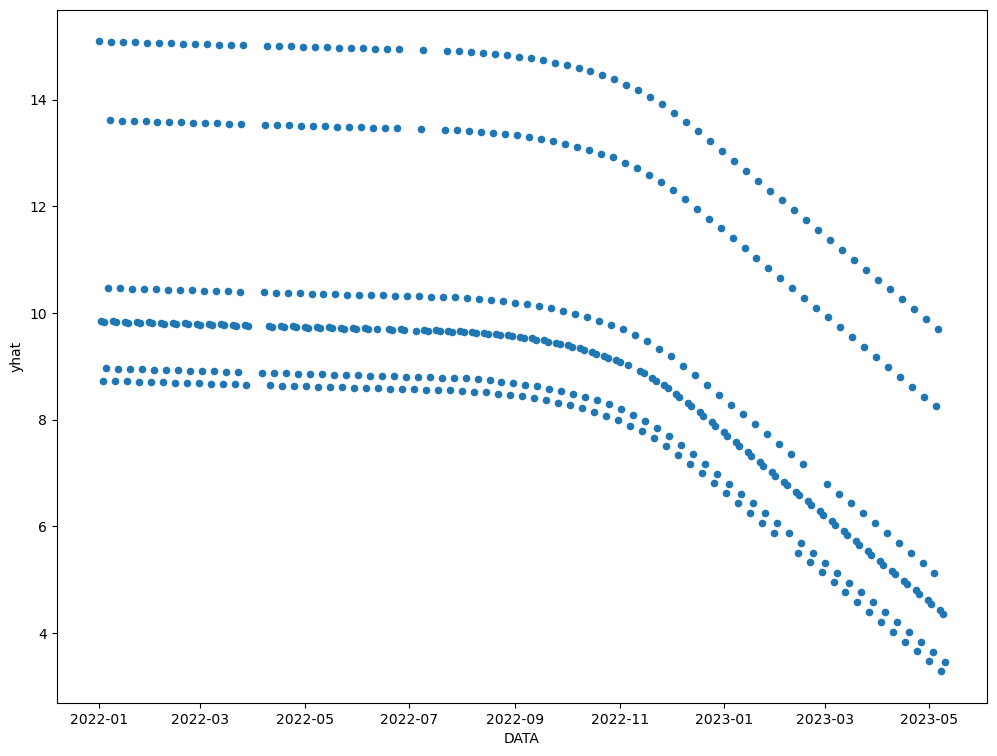

In [14]:
base_Final[(base_Final["DESC_ARTIGO"]==produtos[2]) & (base_Final["STORE"]==lojas[2])].plot(kind='scatter',figsize=(12, 9), x = 'DATA', y = 'SELLOUT')
base_Final[(base_Final["DESC_ARTIGO"]==produtos[2]) & (base_Final["STORE"]==lojas[2])].plot(kind='scatter',figsize=(12, 9), x = 'DATA', y = 'yhat')

In [17]:
base_Final["Comparar"] = base_Final["SELLOUT"] - base_Final["yhat"]

<Axes: title={'center': 'Comparar'}, xlabel='DESC_ARTIGO'>

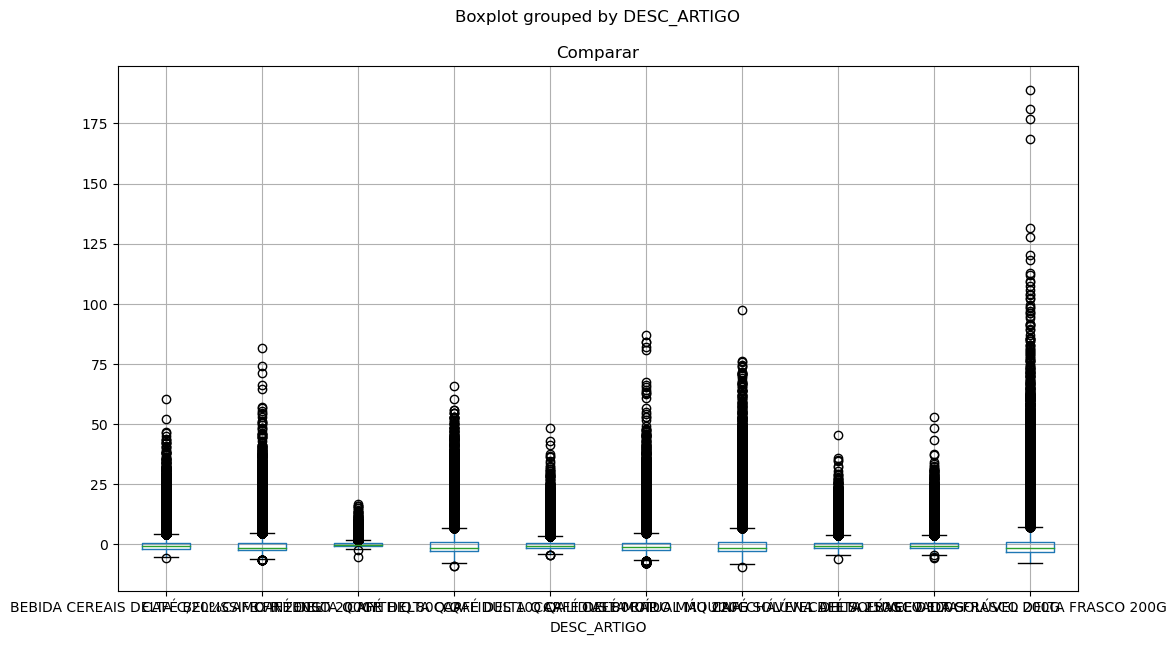

In [18]:
base_Final.boxplot(column='Comparar', by='DESC_ARTIGO', figsize= (12,7))

# Escrever

In [15]:
base_Escrever = base_Final.rename(columns = {"yhat":"Prophet"}).drop(columns = "ds")
base_Escrever = base_Escrever.sort_values(by=["DESC_ARTIGO", "STORE", "DATA"])

In [16]:
base_Escrever = base_Escrever.set_index("DATA")

<Axes: xlabel='DATA'>

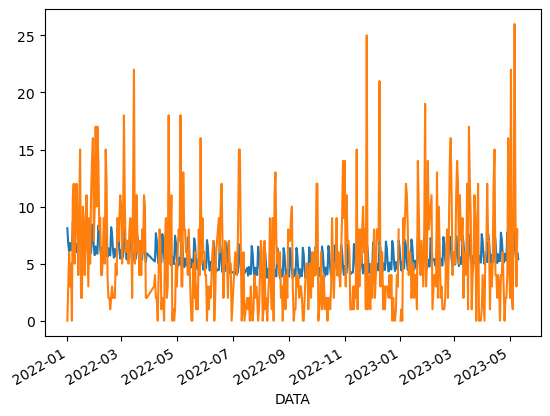

In [17]:
#base_Escrever[(base_Escrever["DESC_ARTIGO"]=="CEVADA SOLÚVEL DELTA FRASCO 200G") & (base_Escrever["STORE"]==9665)]["Prophet"].plot()
#base_Escrever[(base_Escrever["DESC_ARTIGO"]=="CEVADA SOLÚVEL DELTA FRASCO 200G") & (base_Escrever["STORE"]==9665)]["SELLOUT"].plot()

base_Escrever[(base_Escrever["DESC_ARTIGO"]=="CEVADA SOLÚVEL DELTA FRASCO 200G") & (base_Escrever["STORE"]==3)]["Prophet"].plot()
base_Escrever[(base_Escrever["DESC_ARTIGO"]=="CEVADA SOLÚVEL DELTA FRASCO 200G") & (base_Escrever["STORE"]==3)]["SELLOUT"].plot()


<Axes: xlabel='DATA'>

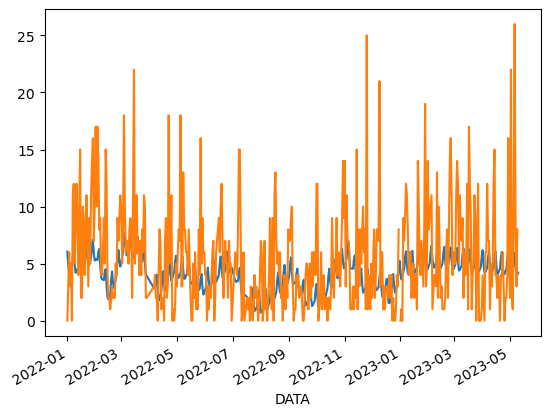

In [22]:
base_Escrever[(base_Escrever["DESC_ARTIGO"]=="CEVADA SOLÚVEL DELTA FRASCO 200G") & (base_Escrever["STORE"]==3)]["Prophet"].plot()
base_Escrever[(base_Escrever["DESC_ARTIGO"]=="CEVADA SOLÚVEL DELTA FRASCO 200G") & (base_Escrever["STORE"]==3)]["SELLOUT"].plot()


In [18]:
base_Escrever.tail()

,STORE,STORE_NAME,DESC_ARTIGO,SELLOUT,Prophet
DATA,,,,,
2023-05-06,464,CNT TELHEIRAS,CEVADA SOLÚVEL DELTA FRASCO 200G,9.0,7.405800
2023-05-07,464,CNT TELHEIRAS,CEVADA SOLÚVEL DELTA FRASCO 200G,8.0,5.746881
2023-05-08,464,CNT TELHEIRAS,CEVADA SOLÚVEL DELTA FRASCO 200G,15.0,4.466372
2023-05-09,464,CNT TELHEIRAS,CEVADA SOLÚVEL DELTA FRASCO 200G,7.0,5.114264
2023-05-10,464,CNT TELHEIRAS,CEVADA SOLÚVEL DELTA FRASCO 200G,NaN,4.632311


In [29]:
escrever_csv(base_Escrever, "Prophet_snif", 1)